# Audio Study

## First libraries and variables import

In [1]:

import sys
from pathlib import Path
import os
import pandas as pd

# Get the absolute path of the folder containing the module
root_dir = Path.cwd().resolve().parent.parent

# Add the folder path to sys.path
sys.path.append(str(root_dir))

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn.preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import torch
from keras.callbacks import EarlyStopping

from transformers import AutoFeatureExtractor, ASTForAudioClassification
from torch.utils.data import DataLoader
import torch.nn as nn

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from config.variables import indiv_sample_path, audio_path, text_path, wav_path, csv_file, audiocsv_file, audio_model_path

from audio_utils import convert_to_wav, transcribe_audio, normalize, WavFileHelper, open_csv_file, load_audio_features, fetch_virality, AudioDataset

## Speech extraction

First of all, we extract the speech from the audios, using one of the best pretrained models for this work. It is important to highlight that this step is not one of the main points of the project. For that reason, there will not be experimentation with different models of the rest of the phases.

In [3]:
# Directory containing the audio files
audio_folder = os.path.join(root_dir, audio_path)
wav_folder = os.path.join(root_dir, wav_path)

# # Directory where the transcribed text files will be saved
# output_folder = os.path.join(root_dir, text_path)

# # Create the output directory if it doesn't exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Iterate over the audio files in the folder
# for filename in os.listdir(audio_folder):
#     if filename.endswith('.mp3'):  # You can adjust the extension according to your audio files
#         audio_file = os.path.join(audio_folder, filename)
#         wav_file = convert_to_wav(audio_file, wav_folder)
#         text = transcribe_audio(wav_file)
        
#         output_file = os.path.splitext(filename)[0] + '.txt'
#         output_path = os.path.join(output_folder, output_file)
#         with open(output_path, 'w') as f:
#             f.write(text)
#         print(f"Transcription of {filename} saved to {output_file}")

## Data Exploration 

### Example of data inspection

In [4]:
indiv_path = os.path.join(root_dir, indiv_sample_path)

ipd.Audio(indiv_path)

**Waveform**

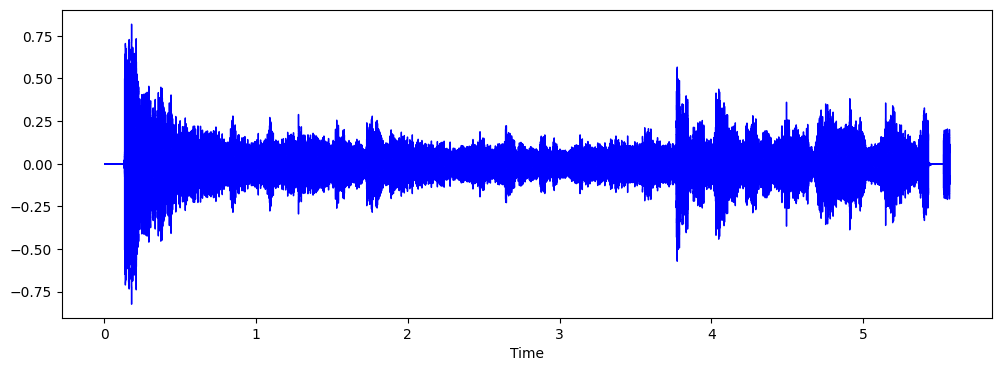

In [5]:
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(indiv_path)
_ = librosa.display.waveshow(data,sr=sample_rate, color="blue")  
ipd.Audio(indiv_path)

**Spectogram**

In [6]:
x , sr = librosa.load(indiv_path)

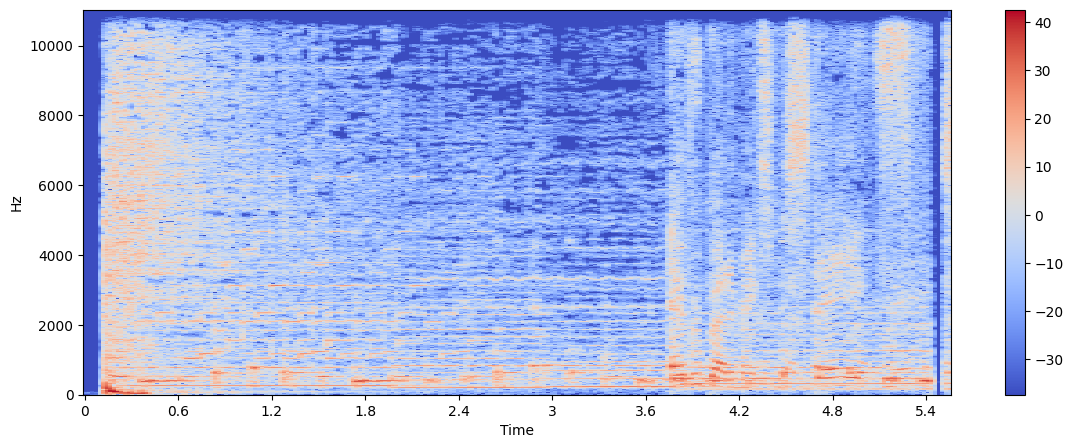

In [7]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

**Log Frequency Axis**

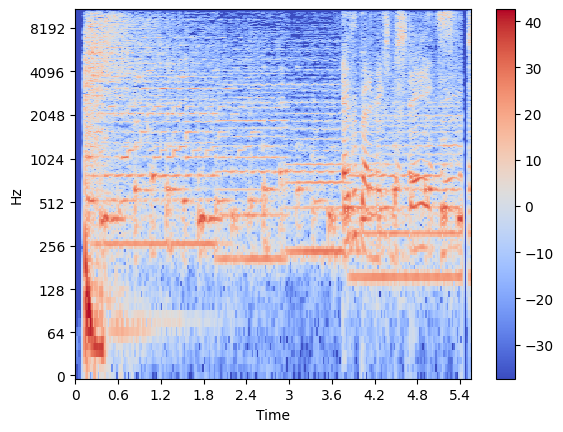

In [8]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### Dataset output addition

In [9]:
# Load the CSV file into a DataFrame
csv_path = os.path.join(root_dir, csv_file)
df = pd.read_csv(csv_path)

df = df[['id', 'norm_virality']]

df['id'] = df['id'].astype(str)

# Display the DataFrame
df.head()

,id,norm_virality
0,6907228749016714497,0.000177
1,6875468410612993286,0.003337
2,6898699405898059010,0.060929
3,6902819837345533186,0.000377
4,6905635666588192002,0.000457


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   object 
 1   norm_virality  1000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


### Audio sample file properties

The next step will be the extraction of the number of audio channels, sample rate and bit-depth. This could be useful for data estandarization before the feature extraction, maybe for a multimodal model with features from text, audio and video.

In [11]:
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in df.iterrows():

    file_name = os.path.join(wav_folder, f"{row['id']}_audio.wav")
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [12]:
audiodf

,num_channels,sample_rate,bit_depth
0,1,16000,16
1,1,16000,16
2,1,16000,16
3,1,16000,16
4,1,16000,16
...,...,...,...
995,1,16000,16
996,1,16000,16
997,1,16000,16
998,1,16000,16


As it is easily observed, due to the fact that all the videos come from the same source, the format is consistent across videos, so not preprocessing of bit-depth, sample-rate or number of channels is required.

## Feature extraction

The next step is feature extraction, which could help in understanding the data and creating models, as previously mentioned. It will be carried out for an example sample to understand how it works, and will later be extended to the entire data set.

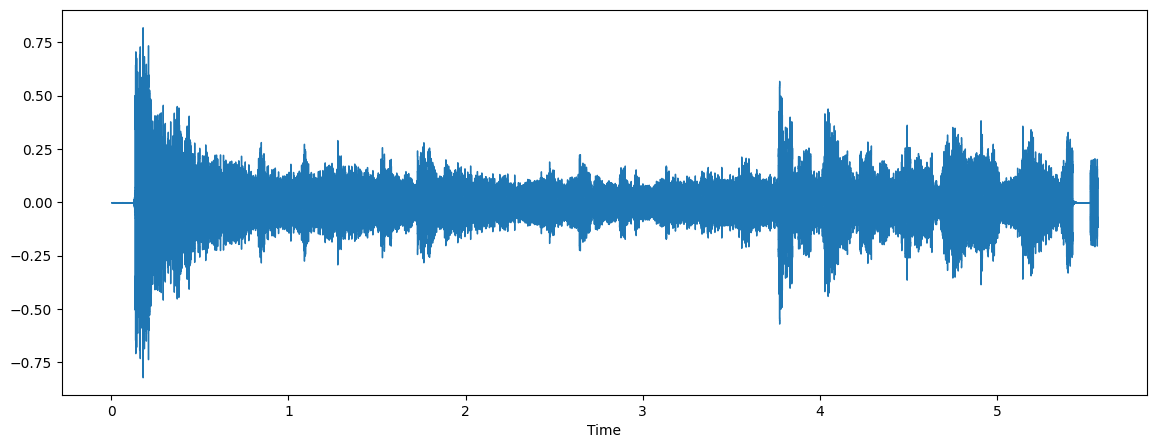

In [13]:
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

### 1. Zero Crossing Rate

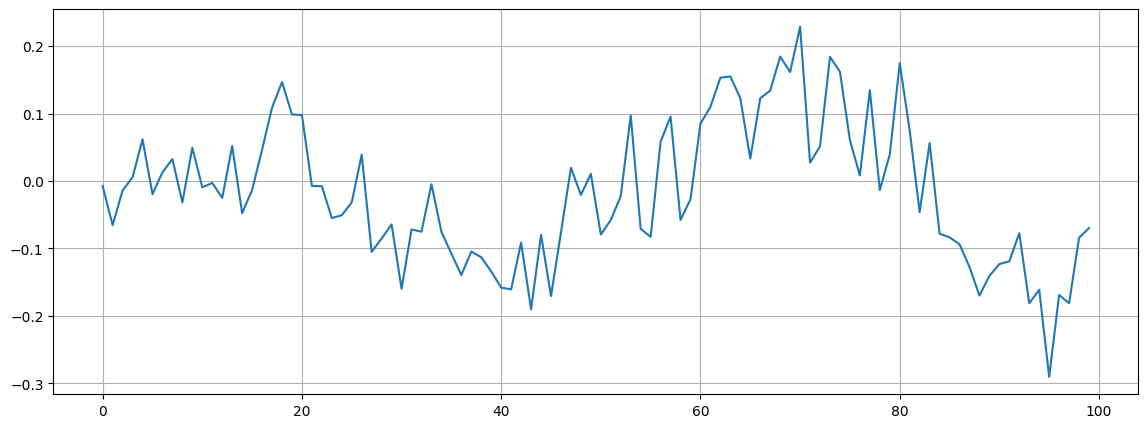

In [14]:
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

More than 10 easily spotted.

In [15]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(zero_crossings.shape)

print(sum(zero_crossings))

(100,)
26


### 2.Spectral Centroid

In [16]:
spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]
spectral_centroids.shape

(240,)

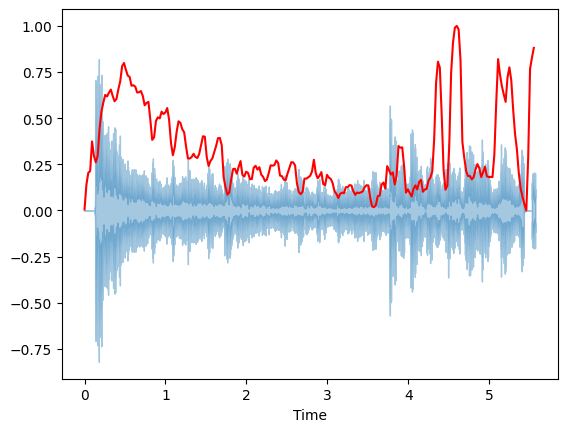

In [17]:
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

### 3.Spectral Rolloff 

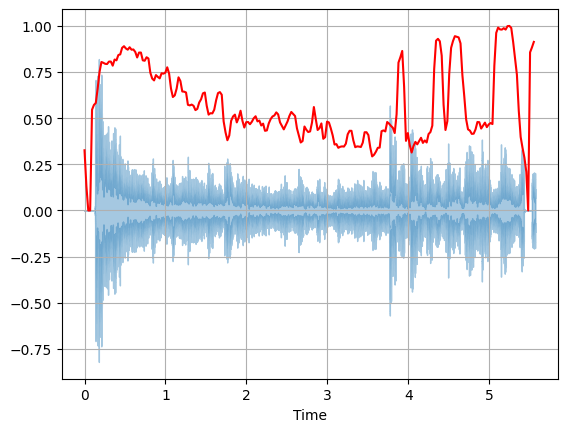

In [18]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=x+0.01, sr=sr)[0]
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.grid()

### 4.MFCC

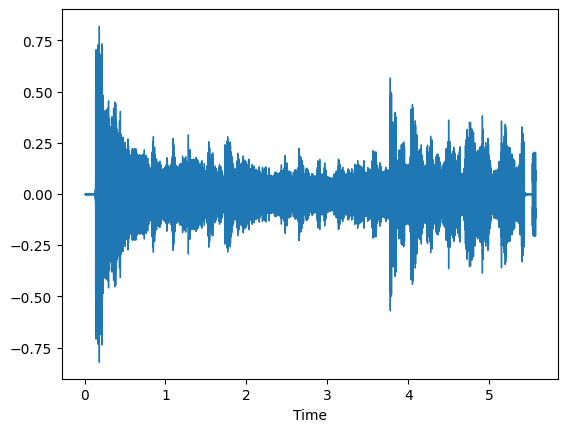

In [19]:
librosa.display.waveshow(x, sr=sr)

(20, 240)


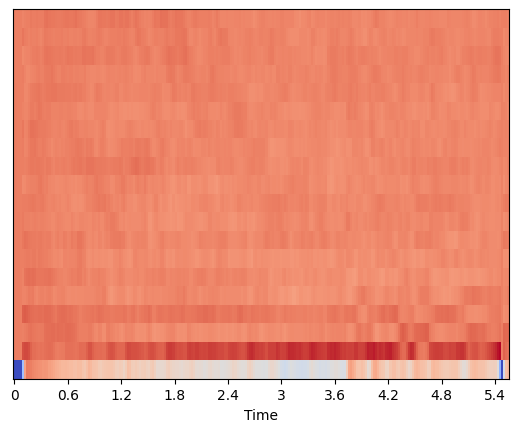

In [20]:
# MFCC
mfccs = librosa.feature.mfcc(y=x, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### MMFC Feature Scaling

In [21]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))

[-5.9604646e-09  0.0000000e+00  0.0000000e+00  0.0000000e+00
  1.5894573e-08 -3.1789146e-08 -1.5894573e-08  7.9472864e-09
 -7.9472864e-09  0.0000000e+00  1.5894573e-08  3.1789146e-08
  0.0000000e+00  0.0000000e+00 -1.5894573e-08  0.0000000e+00
  1.9868216e-09  0.0000000e+00  0.0000000e+00  0.0000000e+00]
[0.9999999  1.         0.9999999  0.99999994 1.0000001  1.0000001
 1.         1.         1.0000001  1.0000001  1.         1.
 1.         0.99999994 1.         1.0000001  0.99999994 1.0000002
 0.9999999  0.99999994]


c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\sklearn\preprocessing\_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\sklearn\preprocessing\_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


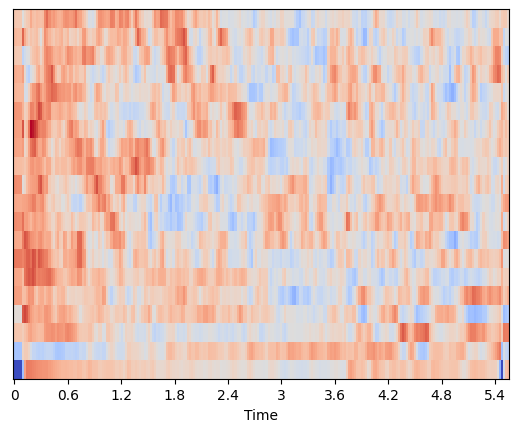

In [22]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### 5. Chroma Frequencies

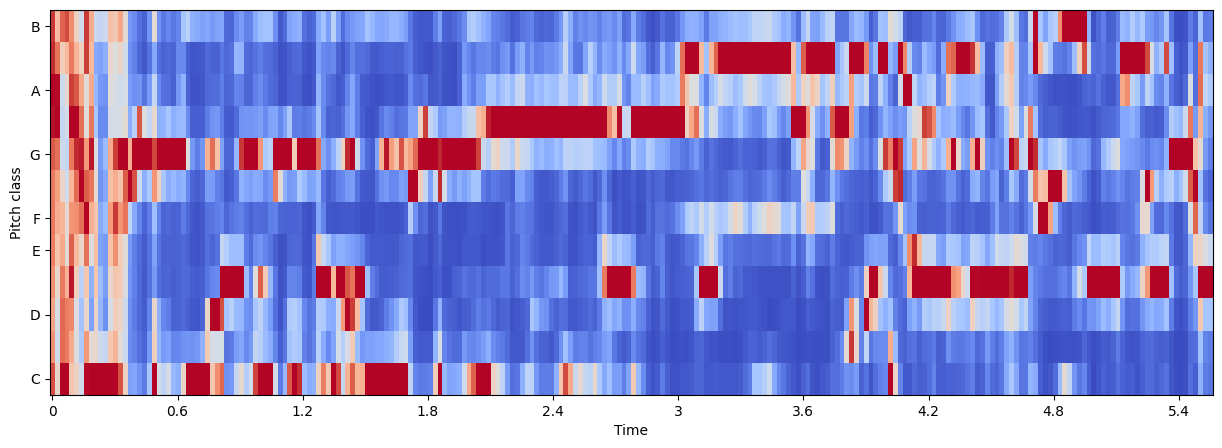

In [23]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(y=x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

## Complete Feature Extraction

It will be extracted:

 + Mel-frequency cepstral coefficients (MFCC)(20 in number. From the literature the first 13th are the most representative)

 + Spectral Centroid

 + Zero Crossing Rate

 + Chroma Frequencies

 + Spectral Roll-off

In [24]:
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

The data will be written to a csv file, as well as the text embeddings, for an easier manipulation and code reproduction.

In [25]:
# Open the new CSV file for writing and write the header
audio_csv = os.path.join(root_dir, audiocsv_file, "audio_features.csv")

# csv writing
# file, writer = open_csv_file(audio_csv, header)

# # Iterate over the WAV files in the folder
# for filename in os.listdir(wav_folder):
#     if filename.endswith('.wav'):  # Adjust file extension if necessary
#         audio_name = os.path.join(wav_folder, filename)
        
#         # Extract video ID from filename
#         video_id = os.path.splitext(filename)[0].split('_')[0]

#         # Load audio features
#         features = load_audio_features(audio_name)

#         # Fetch virality label
#         virality_label = fetch_virality(video_id, df)

#         # Write features and virality label to CSV
#         to_append = f'{video_id} ' + ' '.join(map(str, features)) + f' {virality_label}'
#         writer.writerow(to_append.split())

# # Close the CSV file
# file.close()

## Csv Feature Reading and Treatment

In [26]:
data = pd.read_csv(audio_csv)
data

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,6875317312082201857,0.445574,2747.258011,2020.649122,5297.622403,0.189092,-107.400795,75.834880,-80.086720,28.676441,...,-10.352499,7.441584,-10.581148,8.364483,-4.660430,15.533567,0.937928,10.310131,-3.240670,0.000805
1,6875323773755657474,0.333135,1812.114134,1580.771499,3446.998260,0.106621,-262.609740,120.351950,-31.681631,49.745846,...,-15.107998,13.919560,-10.353311,-0.775463,-3.052701,-3.336031,-6.546474,-2.021772,-1.373575,0.000189
2,6875342937002085633,0.400266,1944.360603,1560.395954,3507.649066,0.115429,-310.880250,126.661850,-46.500230,27.055515,...,0.213525,15.128963,-5.700875,10.273509,-2.030400,6.179650,1.224256,5.150634,0.197958,0.001499
3,6875370613523909890,0.295180,2116.037533,1934.255173,4351.187439,0.120654,-188.172990,107.782160,-39.465355,43.778110,...,-10.360028,1.580873,-17.704420,1.120645,-13.720979,5.554143,-6.436055,2.772507,-3.352244,0.000086
4,6875373441432816898,0.292295,2113.518369,1797.010900,4164.664334,0.122701,-236.509720,97.107090,-63.896763,35.321415,...,-12.574279,1.397874,-15.371344,13.029241,-4.472447,18.715902,4.007404,7.794216,-1.417918,0.000257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6908391851418471682,0.318562,2013.462608,1753.406782,3887.673994,0.123730,-280.911130,75.836140,-20.778652,30.153076,...,-5.502901,-6.103394,-7.896830,3.484443,-11.787608,4.184449,-2.231119,1.629682,4.443437,0.000899
996,6908401262065143045,0.322200,1949.651372,1664.405063,3664.691418,0.119145,-89.844240,118.078300,-60.389492,32.610596,...,-12.539471,0.364483,-21.038690,1.485123,-14.048548,-6.210596,-3.521737,-1.809716,-6.371041,0.000135
997,6908408424610974977,0.568037,3671.581368,2131.155298,6289.955477,0.333884,-249.100570,71.439095,-70.545770,67.354620,...,-10.483207,4.051190,-25.192488,15.851523,-13.278896,14.087984,-15.423230,4.256517,-12.225366,0.000356
998,6908460695461891329,0.412975,1303.624803,1478.083481,2791.345729,0.065727,-429.450350,120.374680,-1.514547,53.847970,...,-3.388240,-6.735516,-3.014581,1.582657,-5.186983,-2.027671,-1.752960,-3.153165,-1.703576,0.000088


In [27]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

In [28]:
# Scaling the Feature columns
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
y = np.array(data['label'])

In [29]:
X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size=0.2, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_Test, y_Test, test_size=0.5, random_state=42)

## Audio Model Creation

In this case, the workflow of the notebooks discussed in class will be followed, starting from simpler deep learning models (you could also start with ML as in text, but that is an indicative example, it has already been seen that the best models are those of Deep Learning) until reaching the most complex, seeking in our case to minimize the loss function (MSE).

### Densenet

In [30]:
model = models.Sequential()

model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(1, activation='linear')) # Linear activation for regression

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# Display model architecture summary 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,369 (790.50 KB)

 Trainable params: 202,369 (790.50 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error,
              metrics = [metrics.mean_absolute_error])  # Using mean squared error loss for regression

In [33]:
history = model.fit(X_train,
                    y_train,
                    epochs=85,
                    batch_size=16,
                    validation_data=(X_valid, y_valid))

Epoch 1/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0166 - mean_absolute_error: 0.0849 - val_loss: 0.0018 - val_mean_absolute_error: 0.0336
Epoch 2/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mean_absolute_error: 0.0496 - val_loss: 0.0011 - val_mean_absolute_error: 0.0257
Epoch 3/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - mean_absolute_error: 0.0407 - val_loss: 6.9515e-04 - val_mean_absolute_error: 0.0199
Epoch 4/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - mean_absolute_error: 0.0378 - val_loss: 5.9058e-04 - val_mean_absolute_error: 0.0188
Epoch 5/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - mean_absolute_error: 0.0319 - val_loss: 3.2185e-04 - val_mean_absolute_error: 0.0123
Epoch 6/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - mean_absolute_error: 0.0307 - val_loss: 3.0631e-04 - val_mean_absolute_error: 0.0119
Epoch 7/85
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0266 -

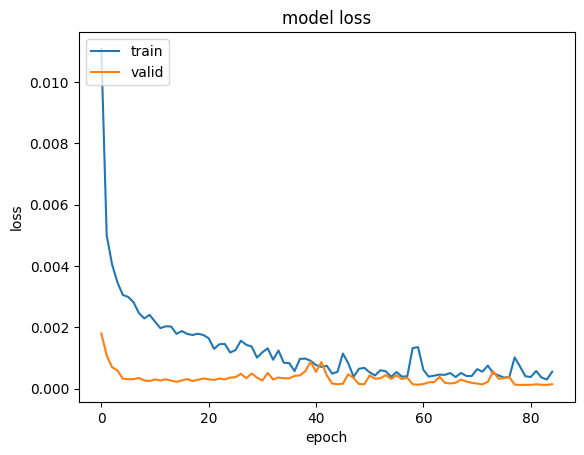

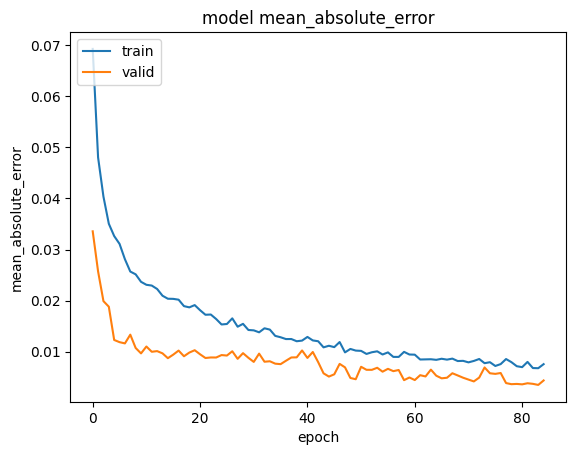

In [34]:
# summarize history for loss (MSE)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for MAE
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [35]:
valid_loss, valid_mae = model.evaluate(X_valid,y_valid)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 1.5333e-04 - mean_absolute_error: 0.0050  


In [36]:
print('Validation MSE: ',valid_loss)

Validation MSE:  0.00014107750030234456


This first model achieves quite decent results. Using the features extracted from the audios, and using a not very complex network, no clear risks of overfitting are observed and the results resemble the minimum MSE values ​​for text models.

In this case, unlike clearer examples such as those seen in class, the features extracted by the model are not humanly interpretable, so it is more complicated than in other examples to listen to the audio and get to know if the predicted virality value is right or wrong.

The next step will be model refinement using CNN, RNN, LSTM and models that bring together several of these networks.

### CNN

It is necessary to add the dimension of the number of channels to the input, and due to the one-dimensional nature of the input, the filters must be 1x1 in this specific case, due to the feature extraction carried out (if this extraction is changed the comparison would not be consistent).

In [37]:
X_train_CNN = torch.tensor(X_train).unsqueeze(2) # Add channel dimension at the end
X_valid_CNN = torch.tensor(X_valid).unsqueeze(2) # Add channel dimension at the end

In [38]:
# Construct model 

num_channels = 1

# Kernel size 1 due to the 1 dimensional data

model = models.Sequential()
model.add(layers.Conv1D(filters=16, kernel_size=(3), input_shape=(X_train.shape[1], num_channels), activation='relu', padding='causal'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv1D(filters=32, kernel_size=(3), activation='relu', padding='causal'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv1D(filters=64, kernel_size=(3), activation='relu', padding='causal'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv1D(filters=128, kernel_size=(3), activation='relu', padding='causal'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv1D(filters=256, kernel_size=(3), activation='relu', padding='causal'))
model.add(layers.Dropout(0.2))


model.add(layers.Flatten())
model.add(layers.Dense(1, activation='linear')) # Linear activation for regression


c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Display model architecture summary 
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 25, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 25, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 25, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 25, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         6,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,505 (537.13 KB)

 Trainable params: 137,505 (537.13 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error,
              metrics = [metrics.mean_absolute_error])  # Using mean squared error loss for regression

In [41]:
history = model.fit(X_train_CNN,
                    y_train,
                    epochs=75,
                    batch_size=64,
                    validation_data=(X_valid_CNN, y_valid))

Epoch 1/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0059 - mean_absolute_error: 0.0439 - val_loss: 2.9360e-04 - val_mean_absolute_error: 0.0109
Epoch 2/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - mean_absolute_error: 0.0303 - val_loss: 2.2698e-04 - val_mean_absolute_error: 0.0088
Epoch 3/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - mean_absolute_error: 0.0268 - val_loss: 1.8904e-04 - val_mean_absolute_error: 0.0082
Epoch 4/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0230 - val_loss: 1.8182e-04 - val_mean_absolute_error: 0.0080
Epoch 5/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - mean_absolute_error: 0.0223 - val_loss: 2.0324e-04 - val_mean_absolute_error: 0.0088
Epoch 6/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0021 - mean_absolute_error: 0.0234 - val_loss: 1.7754e-04 - val_mean_absolute_error: 0.0077
Epoch 7/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - mean_absolute_

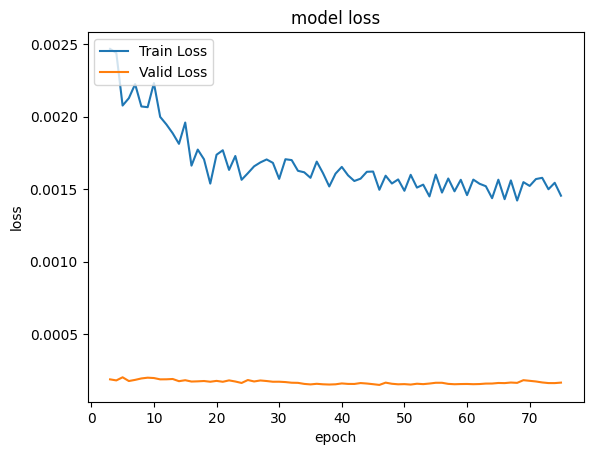

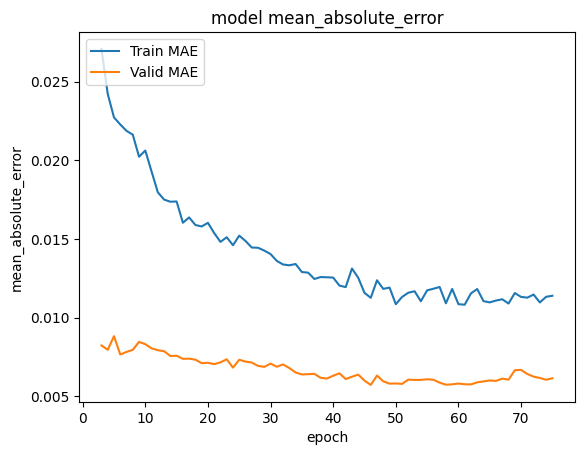

In [42]:
# summarize history for loss (MSE)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(3, len(loss) + 1) # It starts on 10 to see in more detail the majority of epochs

plt.plot(epochs, loss[epochs[0]-1:])
plt.plot(epochs, val_loss[epochs[0]-1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper left')
plt.show()
# summarize history for MAE
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

plt.plot(epochs, mae[epochs[0]-1:])
plt.plot(epochs, val_mae[epochs[0]-1:])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['Train MAE', 'Valid MAE'], loc='upper left')
plt.show()

In [43]:
valid_loss, valid_mae = model.evaluate(X_valid_CNN,y_valid)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8311e-04 - mean_absolute_error: 0.0067 


In [44]:
print('Validation MSE: ',valid_loss)

Validation MSE:  0.00016657034575473517


As can be seen, the results are much better than the previous model, going from 0.0002 to 0.00013. A certain difference is observed between the training set and the validation set, possibly due to a lack of sufficient data, as well as determining characteristics to determine the virality of a video based solely on audio.

It has been proven that with more complex configurations the model tends to overfit and give worse results.

### LSTM

In [45]:
model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(None, 25), return_sequences=True))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 128)      │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, None, 64)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,313 (1.16 MB)

 Trainable params: 305,313 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error,
              metrics = [metrics.mean_absolute_error])  # Using mean squared error loss for regression

In [47]:
X_train_LSTM = X_train.reshape(-1, 1, 25)
X_valid_LSTM = X_valid.reshape(-1, 1, 25)

In [48]:
history = model.fit(X_train_LSTM,
                    y_train,
                    epochs=75,
                    batch_size=64,
                    validation_data=(X_valid_LSTM, y_valid))

Epoch 1/75


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.2472 - mean_absolute_error: 0.4969 - val_loss: 0.2467 - val_mean_absolute_error: 0.4965
Epoch 2/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2453 - mean_absolute_error: 0.4949 - val_loss: 0.2456 - val_mean_absolute_error: 0.4955
Epoch 3/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2452 - mean_absolute_error: 0.4949 - val_loss: 0.2445 - val_mean_absolute_error: 0.4944
Epoch 4/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2434 - mean_absolute_error: 0.4929 - val_loss: 0.2434 - val_mean_absolute_error: 0.4932
Epoch 5/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2425 - mean_absolute_error: 0.4921 - val_loss: 0.2421 - val_mean_absolute_error: 0.4919
Epoch 6/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2414 - mean_absolute_error: 0.4910 - val_loss: 0.2406 - val_mean_absolute_error: 0.4904
Epoch 7/75
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2399 - mean_absolute_error: 0.4895 - val_loss: 0.2390 - val_me

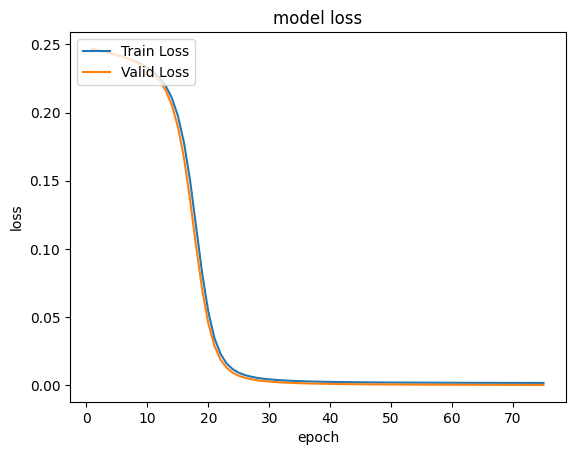

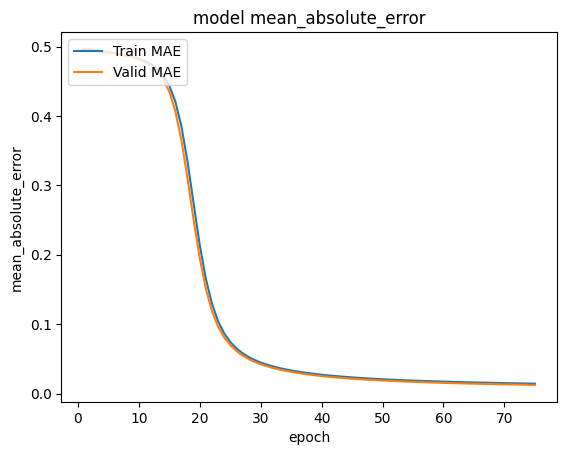

In [49]:
# summarize history for loss (MSE)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1) # It starts on 10 to see in more detail the majority of epochs

plt.plot(epochs, loss[epochs[0]-1:])
plt.plot(epochs, val_loss[epochs[0]-1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper left')
plt.show()
# summarize history for MAE
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

plt.plot(epochs, mae[epochs[0]-1:])
plt.plot(epochs, val_mae[epochs[0]-1:])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['Train MAE', 'Valid MAE'], loc='upper left')
plt.show()

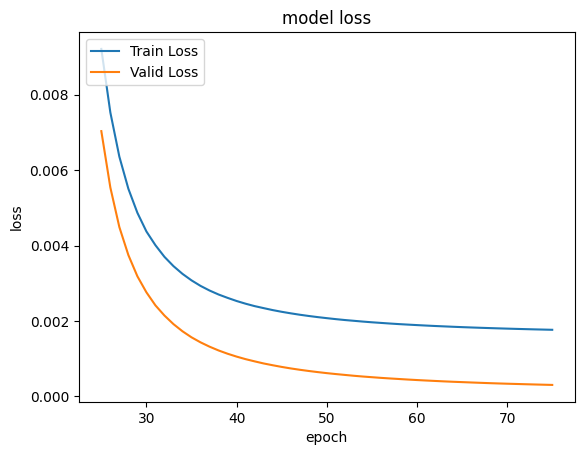

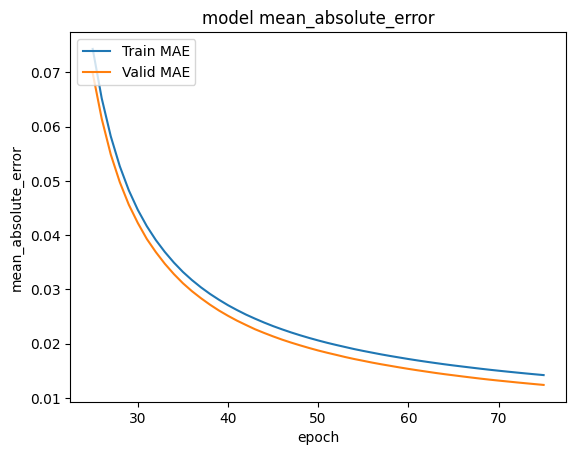

In [50]:
# summarize history for loss (MSE)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(25, len(loss) + 1) # It starts on 10 to see in more detail the majority of epochs

plt.plot(epochs, loss[epochs[0]-1:])
plt.plot(epochs, val_loss[epochs[0]-1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper left')
plt.show()
# summarize history for MAE
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

plt.plot(epochs, mae[epochs[0]-1:])
plt.plot(epochs, val_mae[epochs[0]-1:])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['Train MAE', 'Valid MAE'], loc='upper left')
plt.show()

In [51]:
valid_loss, valid_mae = model.evaluate(X_valid_LSTM,y_valid)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1136e-04 - mean_absolute_error: 0.0124 


In [52]:
print('Validation MSE: ',valid_loss)

Validation MSE:  0.0003045657358597964


The LSTM network seems to be worse than the last ones, although on the other hand it converges in a more progressive way and with less uncertainty. Next, a network is created by mixing both architectures

### CNN & LSTM

In [66]:
#We add a callback that implements early stopping if the validation loss is stale or growing
callback = EarlyStopping(monitor='loss',
                            patience=5,
                            restore_best_weights=True)

In [67]:
model = models.Sequential()

model.add(layers.Conv1D(filters=32, kernel_size=( 3), padding='causal', input_shape=(X_train.shape[1], num_channels), data_format='channels_last'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv1D(filters=64, kernel_size=( 3), padding='causal', input_shape=(X_train.shape[1], num_channels), data_format='channels_last',  kernel_regularizer="l2"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv1D(filters=174, kernel_size=( 3), padding='causal', input_shape=(X_train.shape[1], num_channels), data_format='channels_last',  kernel_regularizer="l2"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv1D(filters=240, kernel_size=( 3), padding='causal', data_format='channels_last',  kernel_regularizer="l2"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Dropout(rate=0.2))
      
model.add(layers.LSTM(units=60, return_sequences=True))
      
model.add(layers.LSTM(units=120,return_sequences=False))
      
model.add(layers.Dropout(rate=0.2)) 

model.add(layers.Dense(units=64,activation="relu"))
model.add(layers.Dropout(rate=0.1)) 

model.add(layers.Flatten())

## Sigmoid Output
model.add(layers.Dense(1, activation='relu'))
      
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 25, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 6, 174)         │        33,582 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 6, 174)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 3, 174)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 3, 174)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 3, 240)         │       125,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 3, 240)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 1, 240)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1, 240)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 60)          │        72,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,367 (1.27 MB)

 Trainable params: 332,367 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Define your early stopping callback
early_stopping_callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [69]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error,
              metrics = [metrics.mean_absolute_error])  # Using mean squared error loss for regression

In [70]:
history = model.fit(X_train_CNN,
                    y_train,
                    epochs=125,
                    batch_size=16,
                    validation_data=(X_valid_CNN, y_valid),
                    callbacks=[early_stopping_callback])

Epoch 1/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.2277 - mean_absolute_error: 0.0057 - val_loss: 2.7954 - val_mean_absolute_error: 0.0049
Epoch 2/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6688 - mean_absolute_error: 0.0060 - val_loss: 2.3093 - val_mean_absolute_error: 0.0048
Epoch 3/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2039 - mean_absolute_error: 0.0062 - val_loss: 1.9058 - val_mean_absolute_error: 0.0055
Epoch 4/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8191 - mean_absolute_error: 0.0070 - val_loss: 1.5706 - val_mean_absolute_error: 0.0046
Epoch 5/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4998 - mean_absolute_error: 0.0080 - val_loss: 1.2924 - val_mean_absolute_error: 0.0041
Epoch 6/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2321 - mean_absolute_error: 0.0058 - val_loss: 1.0617 - val_mean_absolute_error: 0.0041
Epoch 7/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0130 - mean_absolute_error: 0.0089 - val_los

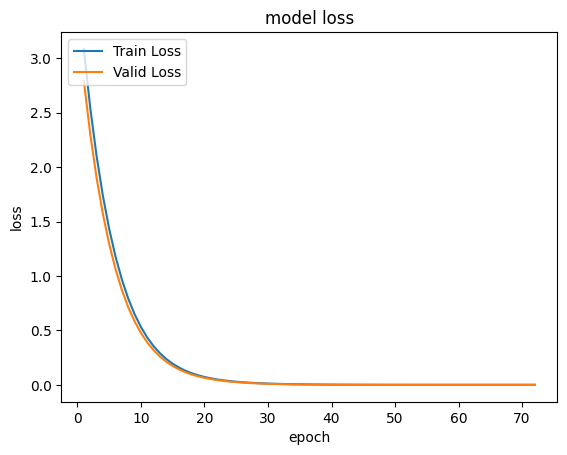

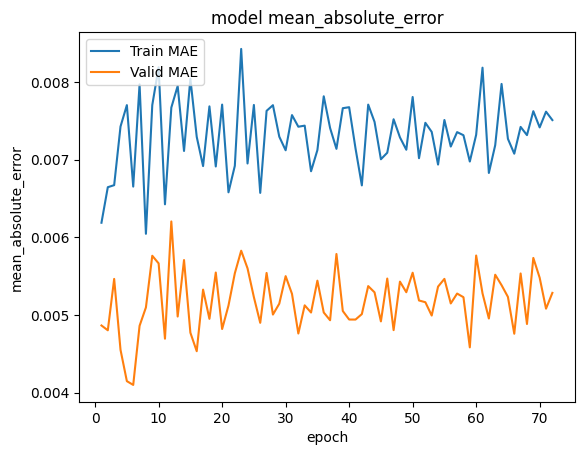

In [71]:
# summarize history for loss (MSE)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1) # It starts on 10 to see in more detail the majority of epochs

plt.plot(epochs, loss[epochs[0]-1:])
plt.plot(epochs, val_loss[epochs[0]-1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper left')
plt.show()

# summarize history for MAE
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

plt.plot(epochs, mae[epochs[0]-1:])
plt.plot(epochs, val_mae[epochs[0]-1:])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['Train MAE', 'Valid MAE'], loc='upper left')
plt.show()

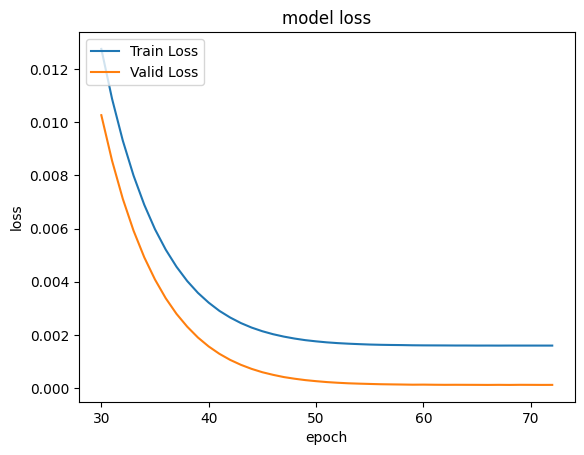

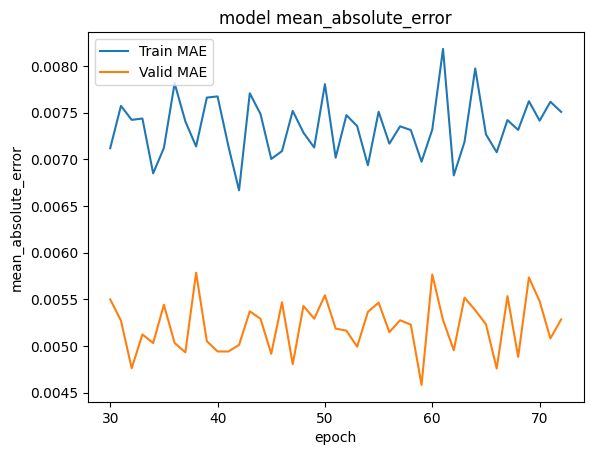

In [72]:
# summarize history for loss (MSE)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(30, len(loss) + 1) # It starts on 10 to see in more detail the majority of epochs

plt.plot(epochs, loss[epochs[0]-1:])
plt.plot(epochs, val_loss[epochs[0]-1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper left')
plt.show()
# summarize history for MAE
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

plt.plot(epochs, mae[epochs[0]-1:])
plt.plot(epochs, val_mae[epochs[0]-1:])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['Train MAE', 'Valid MAE'], loc='upper left')
plt.show()

In [73]:
valid_loss, valid_mae = model.evaluate(X_valid_CNN,y_valid)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2120e-04 - mean_absolute_error: 0.0057 


In [74]:
print('Validation MSE: ',valid_loss)

Validation MSE:  0.00012181104102637619


As can be seen, with this complex network that makes use of various regularizations, dropout and max pooling, together with a mixture of carefully chosen CNN and LSTM layers, the best results are achieved so far, practically reaching a test MSE of 0.0001 (Results may vary slightly with executions, validation error of 0.000116 has been achieved).

Furthermore, the differences between train and validation are smaller than in the previous case, so there would be no apparent reason not to choose this model over previous ones.

### Deep learning pre-trained models

In the same way that it has been carried out in the text notebook, the last case is based on the use of a pre-trained huggingface model.

To do this, the best classification or regression models for audio from social networks will be searched, and one of the most used models will be chosen for this case.

In [78]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

In [79]:
# Split dataset into train and test
train_df, Test_df = train_test_split(df, test_size=0.2, random_state=42)

valid_df, test_df = train_test_split(Test_df, test_size=0.5, random_state=42)

# Create the AudioDataset for train and test sets
train_dataset = AudioDataset(wav_folder, train_df, feature_extractor)
valid_dataset = AudioDataset(wav_folder, valid_df, feature_extractor)

In [80]:
# Define training parameters
batch_size = 32
num_epochs = 15
learning_rate = 1e-4

In [81]:
# Create DataLoader for batching and shuffling data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [66]:
model

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (de

In [67]:
# Select only the encoder/decoder layer and modify the output layer for regression
model.config.num_labels = 1  # Change the number of output labels to 1 for regression
model.classifier.dense = nn.Linear(model.config.hidden_size, 1)  # Replace the classifier with a regression layer

In [68]:
model

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (de

As in the case of text, due to the large number of weights, a fine tuning of 2 hidden layers is performed and, in this case, 15 epochs.

In [69]:
num_layers_to_unfreeze = 2 # For example, unfreeze the top 3 layers

# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the top layers
for name, param in model.named_parameters():
    if 'encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= (12 - num_layers_to_unfreeze):  # Only unfreeze specified number of layers
            param.requires_grad = True    
    
for param in model.classifier.parameters():
    param.requires_grad = True 
            
# Count the number of trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters after unfreezing layers:", total_trainable_params)  


# With 1 layer unfrozen, there are more than 7M trainable parameters
# It has been tested that the number of parameters of the last layer is the same

Number of trainable parameters after unfreezing layers: 14178049


In [75]:
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')  # Initialize with a large value

# Ensure the directory exists before saving the model
best_model_dir = os.path.join(root_dir, audio_model_path)
os.makedirs(best_model_dir, exist_ok=True)

best_model_path = os.path.join(best_model_dir, "best_model.pth")  # Path to save the best model

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Store losses for this epoch

    for inputs, labels in train_dataloader:
        
        optimizer.zero_grad()
        outputs = model(**inputs)
        
        logits = outputs.logits.squeeze(-1)
        loss = criterion(logits, labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())  # Store loss value for this batch

    
    # Calculate mean training loss and MSE for this epoch
    mean_train_loss = np.mean(epoch_train_losses)
    
    train_losses.append(mean_train_loss)

    # Validation loop
    model.eval()
    epoch_val_losses = []  # Store losses for this epoch

    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            
            outputs = model(**inputs)
            
            logits = outputs.logits.squeeze(-1)
            loss = criterion(logits, labels.float())
            
            epoch_val_losses.append(loss.item())  # Store loss value

    # Calculate mean validation loss and MSE for this epoch
    mean_val_loss = np.mean(epoch_val_losses)
    
    val_losses.append(mean_val_loss)

    # Print training and validation metrics
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {mean_train_loss:.4f}, Validation Loss: {mean_val_loss:.4f}")
    
    # Check if current validation loss is better than the best validation loss so far
    if mean_val_loss < best_val_loss:
        # Update best validation loss
        best_val_loss = mean_val_loss
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved at epoch:", epoch+1)

Epoch 1/15, Train Loss: 0.1703, Validation Loss: 0.0490
Best model saved at epoch: 1
Epoch 2/15, Train Loss: 0.0263, Validation Loss: 0.0165
Best model saved at epoch: 2
Epoch 3/15, Train Loss: 0.0076, Validation Loss: 0.0056
Best model saved at epoch: 3
Epoch 4/15, Train Loss: 0.0032, Validation Loss: 0.0046
Best model saved at epoch: 4
Epoch 5/15, Train Loss: 0.0021, Validation Loss: 0.0044
Best model saved at epoch: 5
Epoch 6/15, Train Loss: 0.0015, Validation Loss: 0.0036
Best model saved at epoch: 6
Epoch 7/15, Train Loss: 0.0010, Validation Loss: 0.0037
Epoch 8/15, Train Loss: 0.0008, Validation Loss: 0.0033
Best model saved at epoch: 8
Epoch 9/15, Train Loss: 0.0006, Validation Loss: 0.0034
Epoch 10/15, Train Loss: 0.0005, Validation Loss: 0.0030
Best model saved at epoch: 10
Epoch 11/15, Train Loss: 0.0004, Validation Loss: 0.0031
Epoch 12/15, Train Loss: 0.0004, Validation Loss: 0.0037
Epoch 13/15, Train Loss: 0.0004, Validation Loss: 0.0026
Best model saved at epoch: 13
Epoch

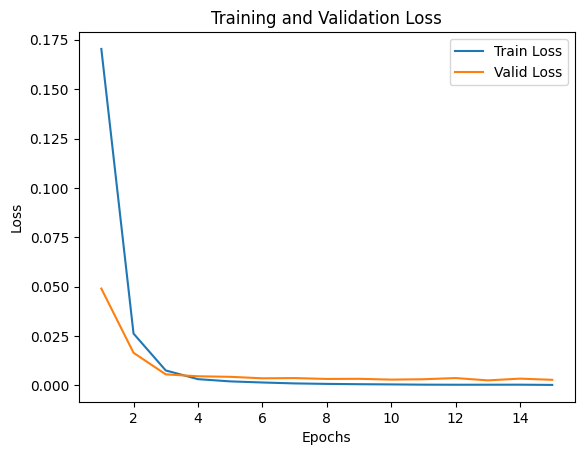

In [76]:
# Plot training and validation losses
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_losses[epochs[0]-1:], label='Train Loss')
plt.plot(epochs, val_losses[epochs[0]-1:], label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

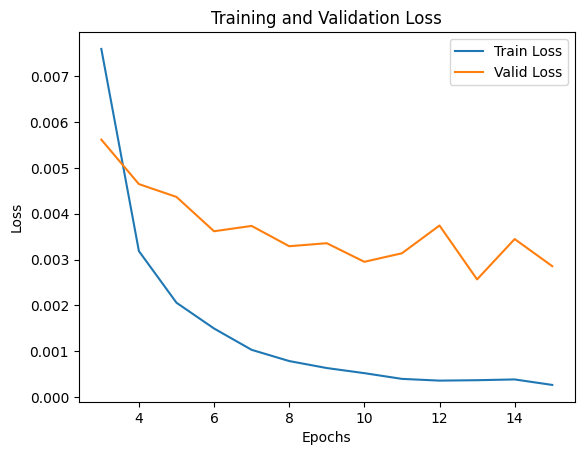

In [77]:
# Plot training and validation losses
epochs = range(3, num_epochs + 1)

plt.plot(epochs, train_losses[epochs[0]-1:], label='Train Loss')
plt.plot(epochs, val_losses[epochs[0]-1:], label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As with the pretrained text model, the results are worse than previous networks, probably due to the lack of hyperparameter optimization and computacional power (Near 7 hours for 15 epochs). This seems to indicate that with greater computational power the best option would probably be, in effect, a pre-trained model using fine-tuning.

In [78]:
num_layers_to_unfreeze = 4 # For example, unfreeze the top 3 layers

# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the top layers
for name, param in model.named_parameters():
    if 'encoder.layer' in name:
        layer_num = int(name.split('.')[3])
        if layer_num >= (12 - num_layers_to_unfreeze):  # Only unfreeze specified number of layers
            param.requires_grad = True    
    
for param in model.classifier.parameters():
    param.requires_grad = True 
            
# Count the number of trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters after unfreezing layers:", total_trainable_params)  


# With 1 layer unfrozen, there are more than 7M trainable parameters
# It has been tested that the number of parameters of the last layer is the same

Number of trainable parameters after unfreezing layers: 28353793


In [79]:
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')  # Initialize with a large value

# Ensure the directory exists before saving the model
best_model_dir = os.path.join(root_dir, audio_model_path)
os.makedirs(best_model_dir, exist_ok=True)

best_model_path = os.path.join(best_model_dir, "best_model2.pth")  # Path to save the best model

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Store losses for this epoch

    for inputs, labels in train_dataloader:
        
        optimizer.zero_grad()
        outputs = model(**inputs)
        
        logits = outputs.logits.squeeze(-1)
        loss = criterion(logits, labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())  # Store loss value for this batch

    
    # Calculate mean training loss and MSE for this epoch
    mean_train_loss = np.mean(epoch_train_losses)
    
    train_losses.append(mean_train_loss)

    # Validation loop
    model.eval()
    epoch_val_losses = []  # Store losses for this epoch

    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            
            outputs = model(**inputs)
            
            logits = outputs.logits.squeeze(-1)
            loss = criterion(logits, labels.float())
            
            epoch_val_losses.append(loss.item())  # Store loss value

    # Calculate mean validation loss and MSE for this epoch
    mean_val_loss = np.mean(epoch_val_losses)
    
    val_losses.append(mean_val_loss)

    # Print training and validation metrics
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {mean_train_loss:.4f}, Validation Loss: {mean_val_loss:.4f}")
    
    # Check if current validation loss is better than the best validation loss so far
    if mean_val_loss < best_val_loss:
        # Update best validation loss
        best_val_loss = mean_val_loss
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved at epoch:", epoch+1)

Epoch 1/15, Train Loss: 0.0989, Validation Loss: 0.0186
Best model saved at epoch: 1
Epoch 2/15, Train Loss: 0.0131, Validation Loss: 0.0041
Best model saved at epoch: 2
Epoch 3/15, Train Loss: 0.0019, Validation Loss: 0.0013
Best model saved at epoch: 3
Epoch 4/15, Train Loss: 0.0008, Validation Loss: 0.0007
Best model saved at epoch: 4
Epoch 5/15, Train Loss: 0.0005, Validation Loss: 0.0006
Best model saved at epoch: 5
Epoch 6/15, Train Loss: 0.0004, Validation Loss: 0.0006
Best model saved at epoch: 6
Epoch 7/15, Train Loss: 0.0003, Validation Loss: 0.0006
Best model saved at epoch: 7
Epoch 8/15, Train Loss: 0.0003, Validation Loss: 0.0005
Best model saved at epoch: 8
Epoch 9/15, Train Loss: 0.0002, Validation Loss: 0.0005
Best model saved at epoch: 9
Epoch 10/15, Train Loss: 0.0002, Validation Loss: 0.0004
Best model saved at epoch: 10
Epoch 11/15, Train Loss: 0.0001, Validation Loss: 0.0004
Best model saved at epoch: 11
Epoch 12/15, Train Loss: 0.0001, Validation Loss: 0.0005
Epoc

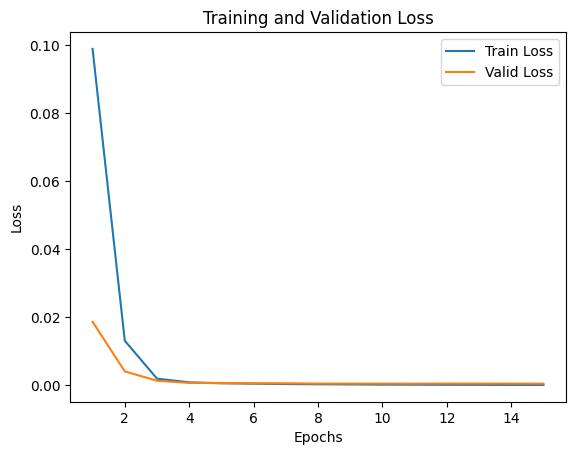

In [80]:
# Plot training and validation losses
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_losses[epochs[0]-1:], label='Train Loss')
plt.plot(epochs, val_losses[epochs[0]-1:], label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

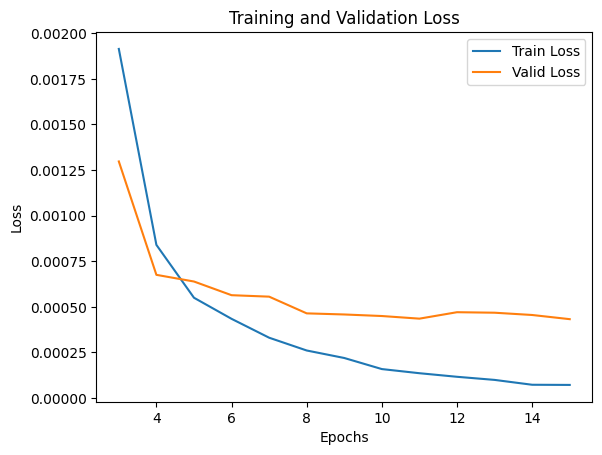

In [81]:
# Plot training and validation losses
epochs = range(3, num_epochs + 1)

plt.plot(epochs, train_losses[epochs[0]-1:], label='Train Loss')
plt.plot(epochs, val_losses[epochs[0]-1:], label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Text Model Testing

Due to the fact that most part of the models have a similar train and validation loss, a model will be chosen and compared with the rest in the test loss.

In this case, to have variety in the types of models and cover more prediction possibilities, the CNN + LSTM model is chosen as the final model (and compared with the pretrained one for the test data).

**Pre-Trained**

In [82]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
best_model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

best_model.config.num_labels = 1  # Change the number of output labels to 1 for regression
best_model.classifier.dense = nn.Linear(best_model.config.hidden_size, 1)  # Replace the classifier with a regression layer

In [83]:
# After training, load the best model for evaluation
best_model_dir = os.path.join(root_dir, audio_model_path)
best_model_path = os.path.join(best_model_dir, "best_model2.pth")  # Path to save the best model

best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [84]:
test_dataset = AudioDataset(wav_folder, test_df, feature_extractor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [85]:
# Set the model to evaluation mode
best_model.eval()
criterion = nn.MSELoss()

# Lists to store predictions and true labels
test_losses = []

# Evaluation loop
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = best_model(**inputs)
        logits = outputs.logits.squeeze(-1)
        loss = criterion(logits, labels.float()) # Calculate loss
        
        test_losses.append(loss.item())  # Store loss value

# Calculate evaluation metric (e.g., mean squared error)
mse = np.mean(test_losses)
print("Mean Squared Error (MSE) on Test Set:", mse)

Mean Squared Error (MSE) on Test Set: 0.008017441105039325


**CNN + LSTM**

In [86]:
#We add a callback that implements early stopping if the validation loss is stale or growing
callback = EarlyStopping(monitor='loss',
                            patience=5,
                            restore_best_weights=True)

In [87]:
model = models.Sequential()

model.add(layers.Conv1D(filters=32, kernel_size=( 3), padding='causal', input_shape=(X_train.shape[1], num_channels), data_format='channels_last'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv1D(filters=64, kernel_size=( 3), padding='causal', input_shape=(X_train.shape[1], num_channels), data_format='channels_last',  kernel_regularizer="l2"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv1D(filters=174, kernel_size=( 3), padding='causal', input_shape=(X_train.shape[1], num_channels), data_format='channels_last',  kernel_regularizer="l2"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv1D(filters=240, kernel_size=( 3), padding='causal', data_format='channels_last',  kernel_regularizer="l2"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(layers.Dropout(rate=0.2))
      
model.add(layers.LSTM(units=60, return_sequences=True))
      
model.add(layers.LSTM(units=120,return_sequences=False))
      
model.add(layers.Dropout(rate=0.2)) 

model.add(layers.Dense(units=64,activation="relu"))
model.add(layers.Dropout(rate=0.1)) 

model.add(layers.Flatten())

## Sigmoid Output
model.add(layers.Dense(1, activation='relu'))
      
model.summary()

c:\Users\juanl\Documents\Master\2o cuatri\ADNE\Trabajo\Tik Tok\tiktok\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 25, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 6, 174)         │        33,582 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 6, 174)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 3, 174)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 3, 174)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 3, 240)         │       125,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 3, 240)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 1, 240)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1, 240)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 1, 60)          │        72,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,367 (1.27 MB)

 Trainable params: 332,367 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Define your early stopping callback
early_stopping_callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [89]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.mean_squared_error,
              metrics = [metrics.mean_absolute_error])  # Using mean squared error loss for regression

In [90]:
history = model.fit(X_train_CNN,
                    y_train,
                    epochs=125,
                    batch_size=16,
                    validation_data=(X_valid_CNN, y_valid),
                    callbacks=[early_stopping_callback])

Epoch 1/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.2216 - mean_absolute_error: 0.0042 - val_loss: 2.7900 - val_mean_absolute_error: 0.0058
Epoch 2/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6631 - mean_absolute_error: 0.0060 - val_loss: 2.3040 - val_mean_absolute_error: 0.0071
Epoch 3/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1997 - mean_absolute_error: 0.0075 - val_loss: 1.9006 - val_mean_absolute_error: 0.0051
Epoch 4/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8136 - mean_absolute_error: 0.0060 - val_loss: 1.5656 - val_mean_absolute_error: 0.0061
Epoch 5/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4930 - mean_absolute_error: 0.0064 - val_loss: 1.2877 - val_mean_absolute_error: 0.0052
Epoch 6/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2274 - mean_absolute_error: 0.0064 - val_loss: 1.0573 - val_mean_absolute_error: 0.0051
Epoch 7/125
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0085 - mean_absolute_error: 0.0073 - val_los

In [102]:
best_model_path = os.path.join(best_model_dir, "Audio_Final_Model.keras")  # Path to save the best model

In [103]:
# Save the model and its weights
model.save(best_model_path)

In [91]:
X_test_CNN = torch.tensor(X_test).unsqueeze(2) # Add channel dimension at the end

In [96]:
test_loss, test_mae = model.evaluate(X_test_CNN,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2228e-05 - mean_absolute_error: 0.0045 


In [97]:
print('Test MSE: ',test_loss)

Test MSE:  2.157464587071445e-05



Finally, it seems that this last model is the most accurate, although there may still be overfitting errors and the pretrained network has much more room for improvement. With this, the audio study concludes.